**This will be my solution to one of the assignment projects of the coure Python Data Science: Regression & Forecasting hosted on the Udemy platform. My solution starts at the EDA section.** 

## Regression Project

Build a linear regression model that predicts the `price` column in the dataset on San Francisco Apartment rentals. Make sure to go through all the the relevant steps of the modelling workflow.

1. Data Cleaning has already been performed on this data
2. Explore the data, keeping an eye on useful features and potential issues 
3. Choose a model validation scheme (simple or cross validation)
4. Fit a Linear Regression Model
5. Evaluate your model - check assumptions, metrics, and coefficient estimates
6. Engineer Features as needed
7. Repeat Steps 2, 4, 5, 6 as needed
8. Once you are ready, fit your final model and report final model performance estimate by scoring on the test data. Report both test R-squared and MAE.

A reasonable goal is to get a validation MAE of <= 500 dollars.

Advice:

1. "Perfect" is the enemy of "Good".
2. You will not get to an MAE of 0, we don't have perfect data, and there is some randomness and emotion in how things like apartment prices are set. 
3. Modelling is challenging, especially if you're new. There isn't a "right" answer, but some models are better than others. Remember - "All Models are wrong, but some are useful" 
4. We will likely end up with different models and performance metrics, and that's ok. You can always implement new ideas after watching the solution video. I didn't do anything too fancy, so you might think of some great ideas I didn't!
5. Enjoy the process, and remember that at some point it's time to let the model go. No amount of feature engineering will achieve a perfect model.

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import KFold
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse

rentals_df = pd.read_csv("../Data/sf_clean.csv") 
rentals_df.head()

,price,sqft,beds,bath,laundry,pets,housing_type,parking,hood_district
0,6800,1600.0,2.0,2.0,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
1,3500,550.0,1.0,1.0,(a) in-unit,(a) both,(c) multi,(b) protected,7.0
2,5100,1300.0,2.0,1.0,(a) in-unit,(a) both,(c) multi,(d) no parking,7.0
3,9000,3500.0,3.0,2.5,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
4,3100,561.0,1.0,1.0,(c) no laundry,(a) both,(c) multi,(d) no parking,7.0


### Data Dictionary

1. Price: The price of the rental and our target variable
2. sqft: The area in square feet of the rental
3. beds: The number of bedrooms in the rental
4. bath: The number of bathrooms in the rental
5. laundry: Does the rental have a laundry machine inside the house, a shared laundry machine, or no laundry on site?
6. pets: Does the rental allow pets? Cats only, dogs only or both cats and dogs?
7. Housing type: Is the rental in a multi-unit building, a building with two units, or a stand alone house? 
8. Parking: Does the apartment off a parking space? No, protected in a garage, off-street in a parking lot, or valet service?
9. Hood district: Which part of San Francisco is the apartment located?

![image info](SFAR_map.png)

In [31]:
rentals_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 989 entries, 0 to 988
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          989 non-null    int64  
 1   sqft           989 non-null    float64
 2   beds           989 non-null    float64
 3   bath           989 non-null    float64
 4   laundry        989 non-null    object 
 5   pets           989 non-null    object 
 6   housing_type   989 non-null    object 
 7   parking        989 non-null    object 
 8   hood_district  989 non-null    float64
dtypes: float64(4), int64(1), object(4)
memory usage: 69.7+ KB


## EDA


This section will be dedicated to test some of the data visualization techniques shown on the course, seaborn.pairplot() for instance. I will mostly just perform some steps in order to check what eill be necessary in the next section.

In [32]:
rentals_df.describe()

,price,sqft,beds,bath,hood_district
count,989.000000,989.000000,989.000000,989.000000,989.000000
mean,3595.035389,976.765420,1.679474,1.390293,7.052578
std,1546.222670,474.629798,1.076710,0.562714,2.404716
min,750.000000,150.000000,0.000000,1.000000,1.000000
25%,2650.000000,650.000000,1.000000,1.000000,6.000000
50%,3300.000000,900.000000,2.000000,1.000000,8.000000
75%,4242.000000,1200.000000,2.000000,2.000000,9.000000
max,19000.000000,3500.000000,6.000000,4.000000,10.000000


By describing we can check if there are possible outliers in the dataset, it appears to be the case with the maximum value in the "price" column. Another feature, "hood_district", is really a categorical feature that is being read by pandas as numerical, the numbers here are just labels and likely wouldn't match the encoding. Let's Fix that.

In [33]:
rentals_df['hood_district'] = rentals_df['hood_district'].astype('object')

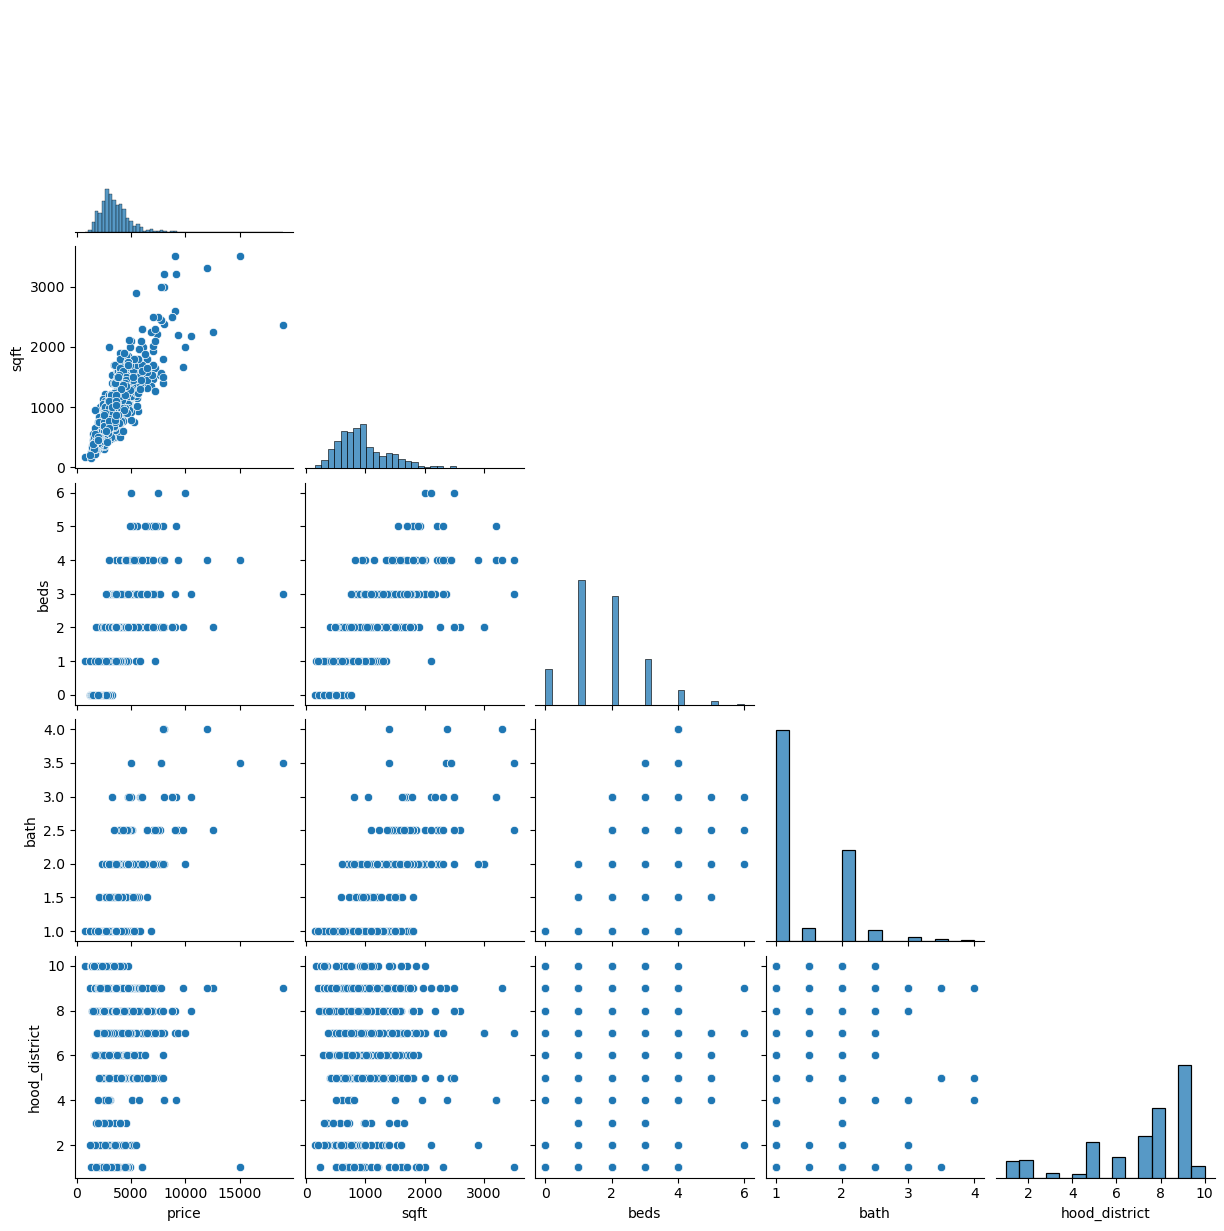

In [34]:
sns.pairplot(rentals_df, corner = True) #to instantly get a look at correlation and histograms.

<Axes: >

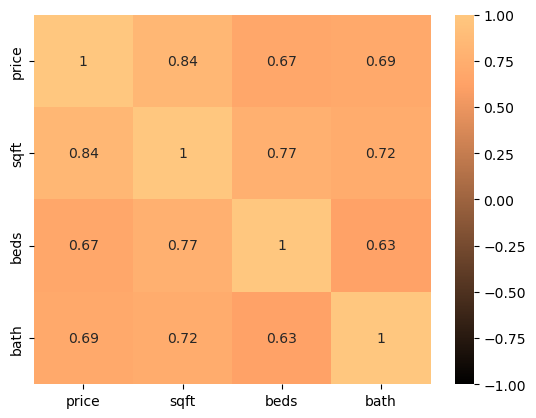

In [35]:
sns.heatmap(rentals_df.corr(numeric_only = True), vmin=-1, vmax=1, cmap = "copper", annot = True)

Our numerical features are highly correlated which coulb be an issue. The feature with the highest correlation with the target variable is 'sqft' and that is to be expected since we want to be paying mostly for space. For categorical features we will use standard barplots.

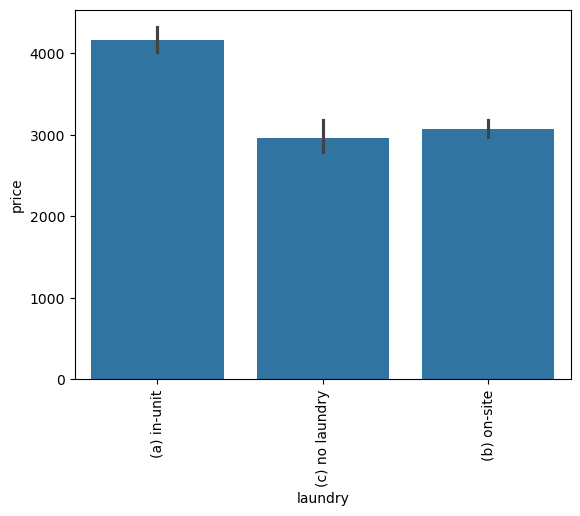

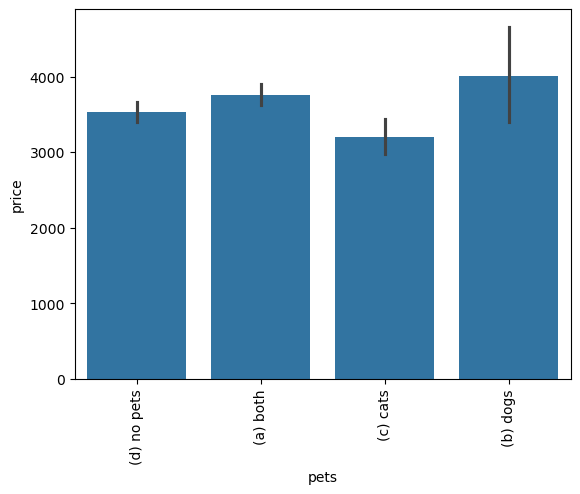

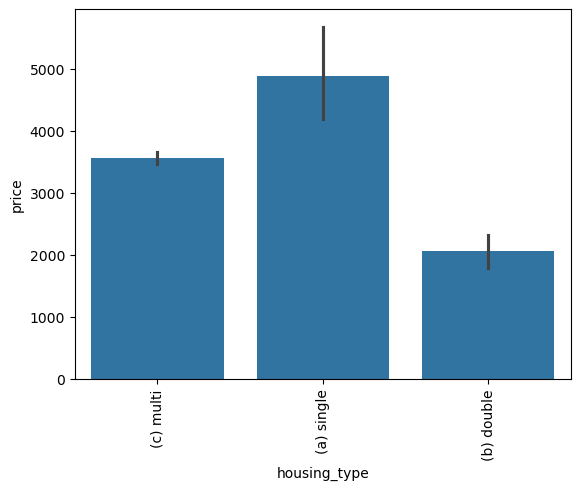

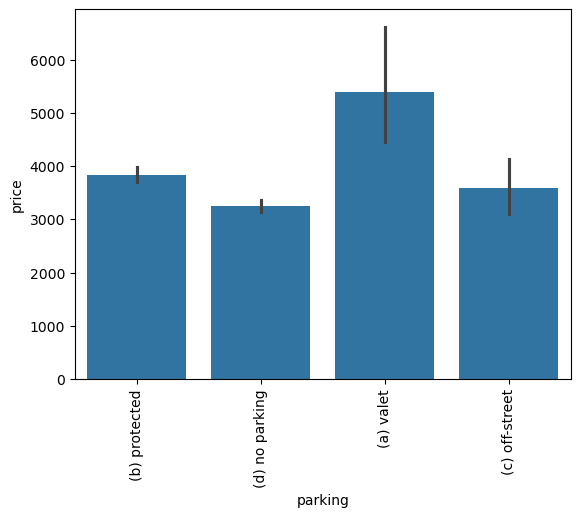

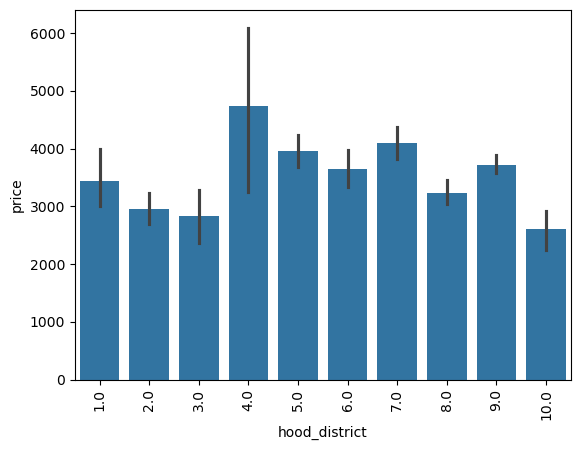

In [36]:
for col in rentals_df.select_dtypes(['object']).columns:
    sns.barplot(data=rentals_df, x=col, y='price')
    plt.xticks(rotation=90)
    plt.show()

I will do groupings in some of the variables reduce dimensionality when encoding with pd.get_dummies.

## Feature Engineering


I will be using the same strategies for these steps as what was shown during the course.

In [37]:
laundry_map = {
    "(a) in-unit": "in_unit",
    "(b) on-site": "not_in_unit",
    "(c) no laundry": "not_in_unit",
}

pet_map = {
    "(a) both": "allows_dogs",
    "(b) dogs": "allows_dogs",
    "(c) cats": "no_dogs",
    "(d) no pets": "no_dogs"
}

housing_type_map = {
    "(a) single": "single",
    "(b) double": "multi",
    "(c) multi": "multi",
}


In [38]:
OHE_df = rentals_df.assign(
    housing_type = rentals_df["housing_type"].map(housing_type_map),
    pets = rentals_df["pets"].map(pet_map),
    laundry = rentals_df["laundry"].map(laundry_map),
)

OHE_df = pd.get_dummies(OHE_df, drop_first=False, dtype=int)
OHE_df.head()

,price,sqft,beds,bath,laundry_in_unit,laundry_not_in_unit,pets_allows_dogs,pets_no_dogs,housing_type_multi,housing_type_single,...,hood_district_1.0,hood_district_2.0,hood_district_3.0,hood_district_4.0,hood_district_5.0,hood_district_6.0,hood_district_7.0,hood_district_8.0,hood_district_9.0,hood_district_10.0
0,6800,1600.0,2.0,2.0,1,0,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0
1,3500,550.0,1.0,1.0,1,0,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,5100,1300.0,2.0,1.0,1,0,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,9000,3500.0,3.0,2.5,1,0,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0
4,3100,561.0,1.0,1.0,0,1,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0


Scaling the numerical variables.

In [39]:
from sklearn.preprocessing import MinMaxScaler 
scaler = MinMaxScaler().set_output(transform="pandas")
scaler.fit(OHE_df)

OHE_scaled_df = scaler.transform(OHE_df)
OHE_scaled_df.head()

,price,sqft,beds,bath,laundry_in_unit,laundry_not_in_unit,pets_allows_dogs,pets_no_dogs,housing_type_multi,housing_type_single,...,hood_district_1.0,hood_district_2.0,hood_district_3.0,hood_district_4.0,hood_district_5.0,hood_district_6.0,hood_district_7.0,hood_district_8.0,hood_district_9.0,hood_district_10.0
0,0.331507,0.432836,0.333333,0.333333,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.150685,0.119403,0.166667,0.000000,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.238356,0.343284,0.333333,0.000000,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.452055,1.000000,0.500000,0.500000,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.128767,0.122687,0.166667,0.000000,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Data Splitting

In [41]:
from sklearn.model_selection import train_test_split

target = "price"
drop_cols = [
    "pets_no_dogs",
    "housing_type_single",
]

X = sm.add_constant(OHE_scaled_df.drop([target] + drop_cols, axis=1))

y = OHE_scaled_df[target]
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=2023)

## Model Fitting & Validation Scoring

In [42]:
def cross_val(X, y, n_splits):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=2023)

    cv_lm_tr_r2s = []
    cv_lm_tr_mae = []
    cv_lm_val_r2s = []
    cv_lm_val_mae = []
    
    for train_ind, val_ind in kf.split(X, y):
        # Subset data based on CV folds
        X_train, y_train = X.iloc[train_ind], y.iloc[train_ind]
        X_val, y_val = X.iloc[val_ind], y.iloc[val_ind]
        # Fit the Model on fold's training data
        model = sm.OLS(y_train, X_train).fit()
        # Append Validation score to list 
        cv_lm_tr_r2s.append(r2(y_train, model.predict(X_train)))
        cv_lm_tr_mae.append(mae(y_train, model.predict(X_train)))
        cv_lm_val_r2s.append(r2(y_val, model.predict(X_val),))
        cv_lm_val_mae.append(mae(y_val, model.predict(X_val),))
        
        
    print(f"All Training R2s: {[round(x, 3) for x in cv_lm_tr_r2s]}")
    print(f"Training R2s: {round(np.mean(cv_lm_tr_r2s), 3)} +- {round(np.std(cv_lm_tr_r2s), 3)}")
    
    print(f"Training MAEs: {[round(x, 3) for x in cv_lm_tr_mae]}")
    print(f"Training MAEs: {round(np.mean(cv_lm_tr_mae), 3)} +- {round(np.std(cv_lm_tr_mae), 3)}")    
        
    print(f"All Validation R2s: {[round(x, 3) for x in cv_lm_val_r2s]}")
    print(f"Cross Val R2s: {round(np.mean(cv_lm_val_r2s), 3)} +- {round(np.std(cv_lm_val_r2s), 3)}")

    print(f"All Validation MAEs: {[round(x, 3) for x in cv_lm_val_mae]}")
    print(f"Cross Val MAEs: {round(np.mean(cv_lm_val_mae), 3)} +- {round(np.std(cv_lm_val_mae), 3)}")
    
    return model
    
model = cross_val(X, y, 5)

All Training R2s: [0.756, 0.761, 0.752, 0.789, 0.755]
Training R2s: 0.762 +- 0.014
Training MAEs: [np.float64(0.027), np.float64(0.027), np.float64(0.026), np.float64(0.026), np.float64(0.028)]
Training MAEs: 0.027 +- 0.001
All Validation R2s: [0.779, 0.75, 0.773, 0.676, 0.781]
Cross Val R2s: 0.752 +- 0.04
All Validation MAEs: [np.float64(0.027), np.float64(0.027), np.float64(0.029), np.float64(0.03), np.float64(0.024)]
Cross Val MAEs: 0.027 +- 0.002


## Assumptions Checking

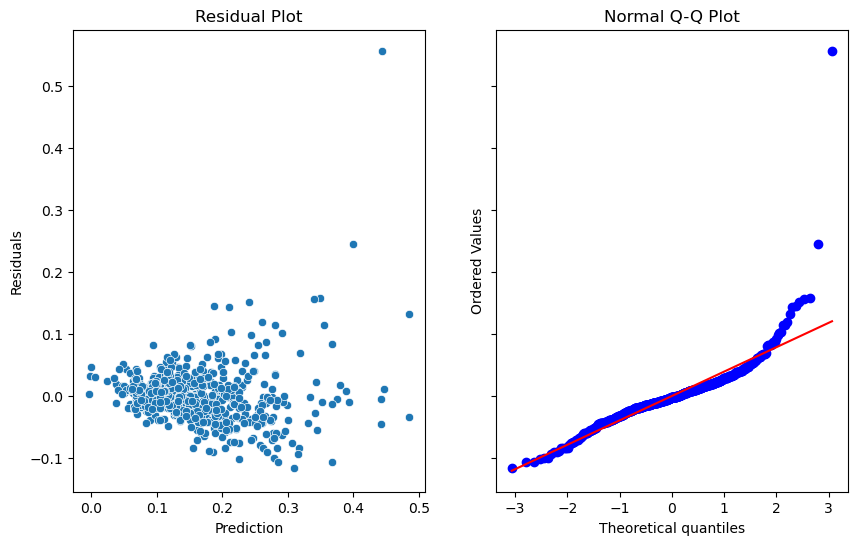

In [45]:
def residual_analysis_plots(model):
    
    import scipy.stats as stats
    import matplotlib.pyplot as plt
    
    predictions = model.predict()
    residuals = model.resid
    
    fig, ax = plt.subplots(1, 2, sharey="all", figsize=(10, 6))
    
    sns.scatterplot(x=predictions, y=residuals, ax=ax[0])
    ax[0].set_title("Residual Plot")
    ax[0].set_xlabel("Prediction")
    ax[0].set_ylabel("Residuals")
    
    stats.probplot(residuals, dist="norm", plot=ax[1])
    ax[1].set_title("Normal Q-Q Plot")  
residual_analysis_plots(model)

In [48]:
influence = model.get_influence()
inf_summary_df = influence.summary_frame()
inf_summary_df["cooks_d"].sort_values(ascending=False).head()

253    0.523047
602    0.093469
206    0.071548
809    0.032698
863    0.030059
Name: cooks_d, dtype: float64

## Final Model Fit & Test Scoring

In [49]:
final_model = sm.OLS(y, X).fit()

final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     136.3
Date:                Tue, 17 Sep 2024   Prob (F-statistic):          2.98e-225
Time:                        16:35:54   Log-Likelihood:                 1383.7
No. Observations:                 791   AIC:                            -2729.
Df Residuals:                     772   BIC:                            -2641.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0299      0.005      5.567      0.000       0.019       0.040
sqft                       0.3553      0.020     17.635      0.000       0.316       0.395
beds                       0.0444      0.014      3.193      0.001       0.017       0.072
bath                       0.0724      0.012      5.912      0.000       0.048       0.096
laundry_in_unit            0.0227      0.003      6.752      0.000       0.016       0.029
laundry_not_in_unit        0.0072      0.003      2.289      0.022       0.001       0.013
pets_allows_dogs          -0.0012      0.003     -0.370      0.712      -0.008       0.005
housing_type_multi         0.0036      0.009      0.394      0.693      -0.014       0.021
parking_(a) valet          0.0542      0.007      7.720      0.000       0.040       0.068
parking_(b) protected     -0.0108      0.003     -3.207      0.001      -0.017      -0.004
parking_(c) off-street     0.0034      0.006      0.536      0.592      -0.009       0.016
parking_(d) no parking    -0.0170      0.003     -4.971      0.000      -0.024      -0.010
hood_district_1.0         -0.0007      0.007     -0.104      0.917      -0.013       0.012
hood_district_2.0         -0.0054      0.007     -0.807      0.420      -0.019       0.008
hood_district_3.0         -0.0135      0.011     -1.259      0.209      -0.035       0.008
hood_district_4.0          0.0037      0.012      0.307      0.759      -0.020       0.028
hood_district_5.0          0.0200      0.005      3.852      0.000       0.010       0.030
hood_district_6.0          0.0210      0.006      3.389      0.001       0.009       0.033
hood_district_7.0          0.0267      0.005      5.655      0.000       0.017       0.036
hood_district_8.0          0.0128      0.004      3.170      0.002       0.005       0.021
hood_district_9.0          0.0073      0.004      1.921      0.055      -0.000       0.015
hood_district_10.0        -0.0421      0.008     -5.525      0.000      -0.057      -0.027
==============================================================================
Omnibus:                      727.514   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            63691.551
Skew:                           3.753   Prob(JB):                         0.00
Kurtosis:                      46.315   Cond. No.                     3.40e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.33e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [53]:
print(f"Test R2: {r2(y_test, final_model.predict(X_test))}")

Test R2: 0.7763133070221163
